Bert-CLS-Attention

In [2]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from bertviz import head_view, model_view

In [ ]:
#matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
#matplotlib.rcParams['font.family'] = 'sans-serif'

tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

# corpus
with open("F:/project/Attention/corpus2.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]
  

all_attentions = []

for corpus_index, text in enumerate(corpus):
    sentences = text.split('。')[:-1]
    input_text = "[CLS] " + "[SEP] [CLS] ".join(sentences) + "[SEP]"

    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)

    input_ids = inputs['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    cls_positions = [pos for pos, token in enumerate(tokens) if token == "[CLS]"]
    num_sentences = len(cls_positions) - 1

    for layer in range(12):
        #all_heads_attention = outputs.attentions[layer][0].mean(dim=0)
        all_heads_attention = outputs.attentions[layer][0][10,:,:]
        sentence_attention = torch.zeros((num_sentences, num_sentences))

        for i in range(num_sentences):
            for j in range(num_sentences):
                sentence_attention[i, j] = all_heads_attention[cls_positions[i + 1], cls_positions[j + 1]]
        
        #mean = torch.mean(sentence_attention, dim=-1, keepdim=True)
        #std = torch.std(sentence_attention, dim=-1, keepdim=True)


        #mean = torch.mean(sentence_attention)
        #std = torch.std(sentence_attention)

        #sentence_attention_normalized = (sentence_attention - mean) / std
        
        all_attentions.append(sentence_attention)
        print(corpus_index, layer)



0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11


In [ ]:
def transform_matrix(matrix):
    tril_indices = np.tril_indices_from(matrix, k=-1)
    transformed_matrix = np.full(matrix.shape, np.nan) 
    transformed_matrix[tril_indices] = matrix[tril_indices]  
    return transformed_matrix

cut_matrices = []

for matrix in all_attentions:
    matrix = matrix.detach().numpy()
    cut_matrix = transform_matrix(matrix)
    cut_matrices.append(cut_matrix)

print(cut_matrices[0])


flattened_matrices = []

for matrix in cut_matrices:
    flattened_matrix = matrix.flatten()
    valid_indices = ~np.isnan(flattened_matrix) 
    mean = np.mean(1-flattened_matrix[valid_indices])
    std = np.std(1-flattened_matrix[valid_indices])
    final = ((1-flattened_matrix[valid_indices]) - mean) / std
    flattened_matrices.append(final)

flattened_matrices = np.array(flattened_matrices)
print(flattened_matrices[0])


[[       nan        nan        nan        nan]
 [0.17882647        nan        nan        nan]
 [0.00867567 0.00385468        nan        nan]
 [0.00107321 0.00308788 0.0198063         nan]]
[-2.22580211  0.42373187  0.49880276  0.542115    0.51074318  0.2504093 ]


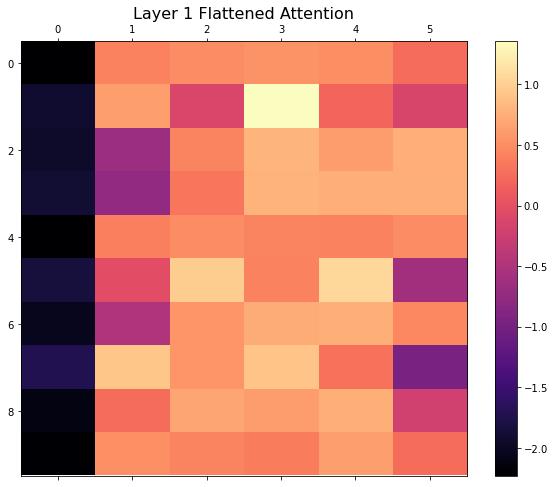

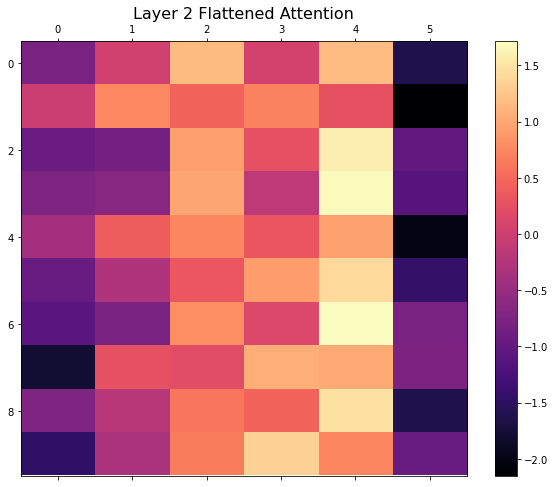

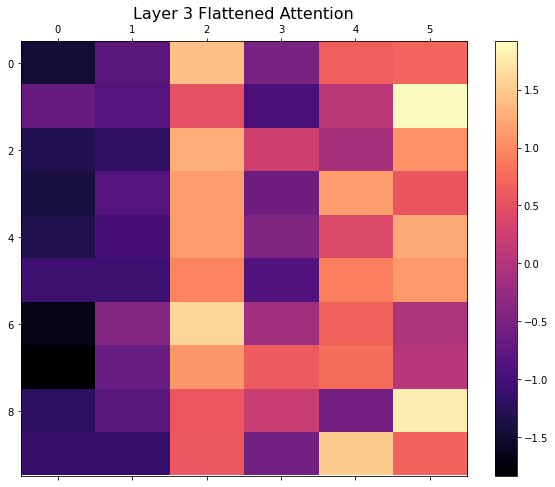

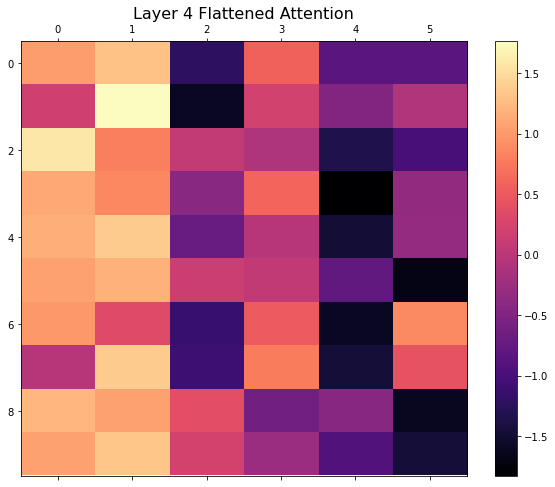

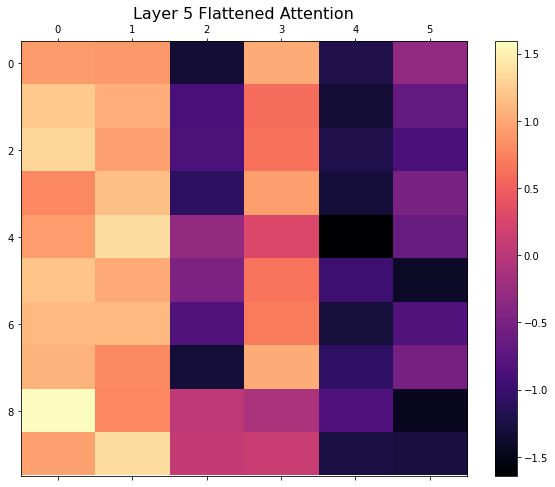

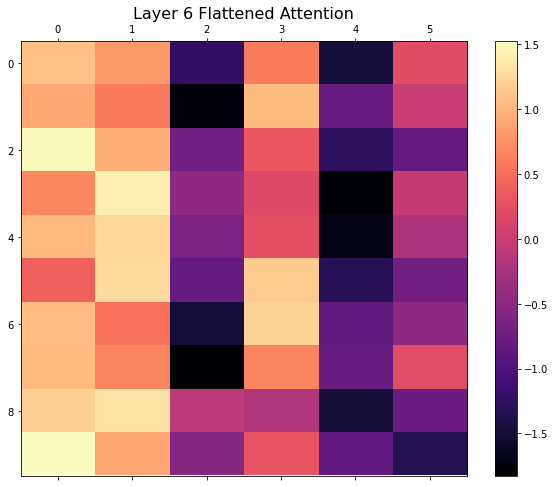

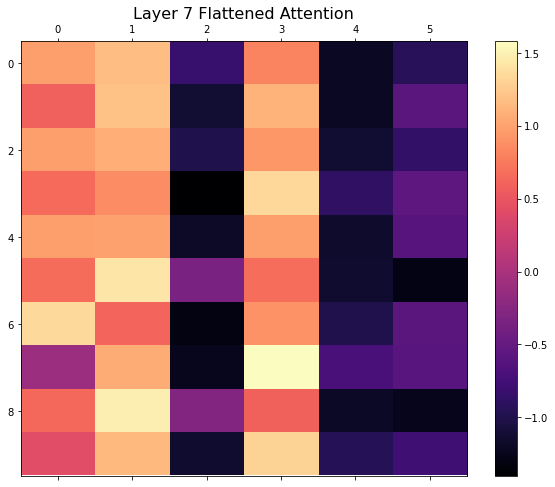

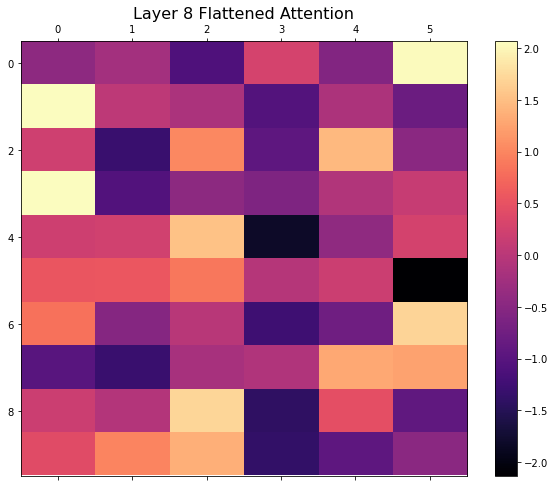

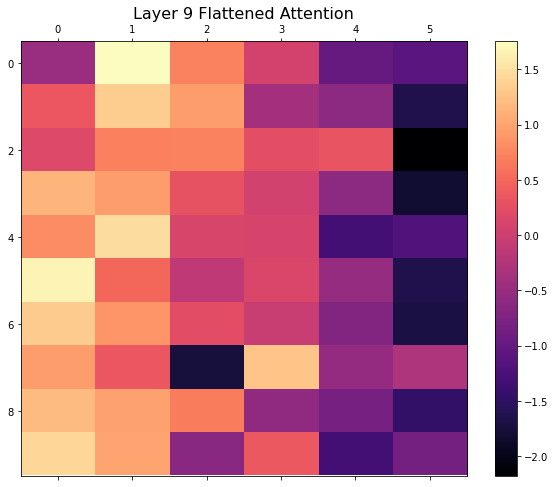

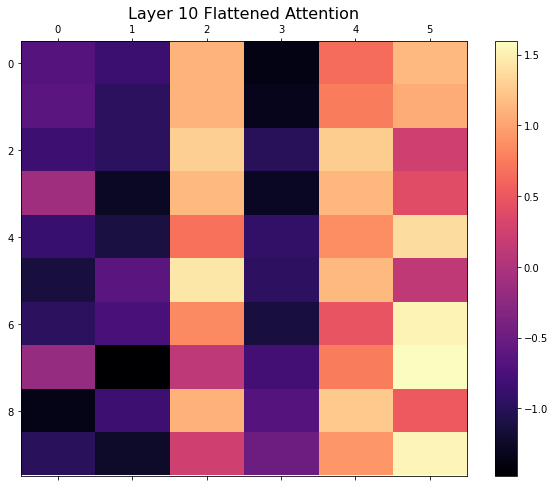

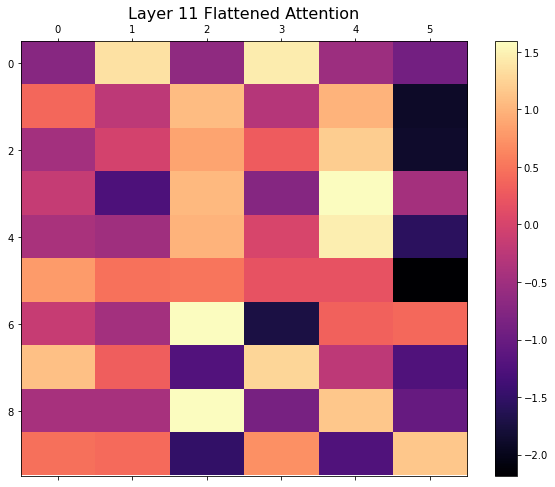

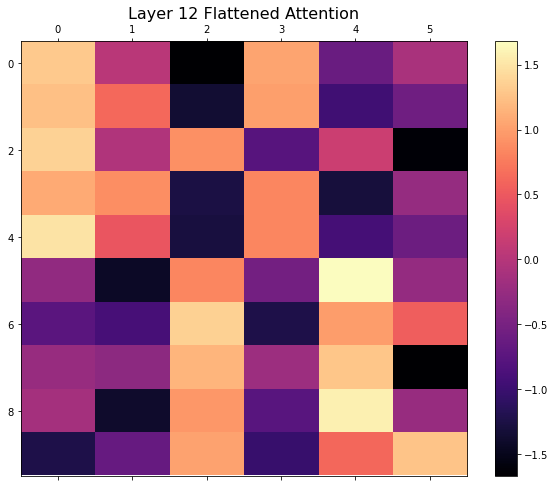

Layer 12 matrices saved to F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-attention.txt


In [ ]:
layers_matrices = {layer: [] for layer in range(1, 13)}
for i, matrix in enumerate(flattened_matrices):
    layer = i % 12 + 1  
    if 1 <= layer <= 12:
        layers_matrices[layer].append(matrix)

for layer, matrices in layers_matrices.items():
    flat_matrices = []
    for matrix in matrices:
        flat_matrix = matrix
        flat_matrices.append(flat_matrix)

    stacked_matrix = np.vstack(flat_matrices)

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(stacked_matrix, cmap='magma', aspect='auto')
    ax.axhline(y = 9.5, color = 'w', linestyle = '-', linewidth = 2)
    ax.set_title(f'Layer {layer} Flattened Attention', fontsize=16)
    fig.colorbar(cax)

    plt.show()

    if layer == 12:
        save_path = 'F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-attention.txt'
        np.savetxt(save_path, stacked_matrix[:20], fmt='%f') 
        print(f'Layer {layer} matrices saved to {save_path}')

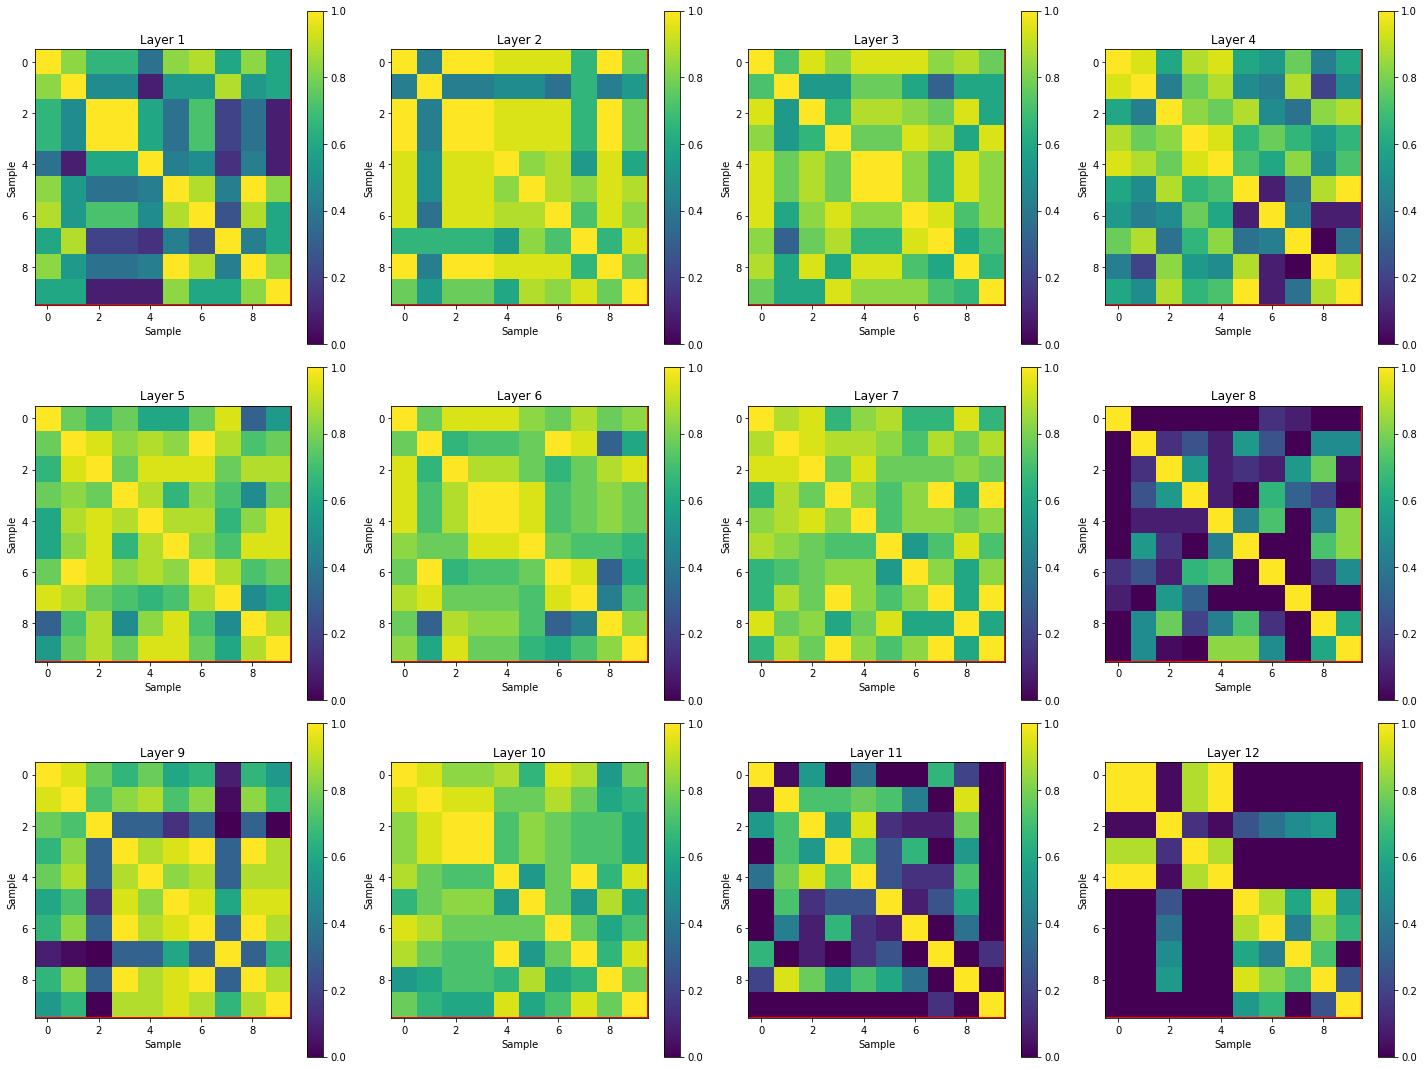

In [ ]:
from scipy.stats import spearmanr
def calc_spearman_matrices(flattened_matrices, layers=12, samples=10):
    layer_matrices = []
    for layer in range(layers):
        spearman_matrix = np.zeros((samples, samples))
        for i in range(samples):
            for j in range(samples):
                matrix_i = flattened_matrices[i*layers + layer]
                matrix_j = flattened_matrices[j*layers + layer]
                rho, _ = spearmanr(matrix_i, matrix_j)
                spearman_matrix[i, j] = rho
        layer_matrices.append(spearman_matrix)
    return layer_matrices

spearman_matrices = calc_spearman_matrices(flattened_matrices)

fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(spearman_matrices[i], cmap = "viridis", vmin=0, vmax=1)
    ax.set_title(f'Layer {i+1}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Sample')
    plt.colorbar(im, ax=ax)
    ax.axhline(y = 9.5, color = 'r', linestyle = '-', linewidth = 2)
    ax.axvline(x = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.tight_layout()
plt.show()


CLS-Embedding

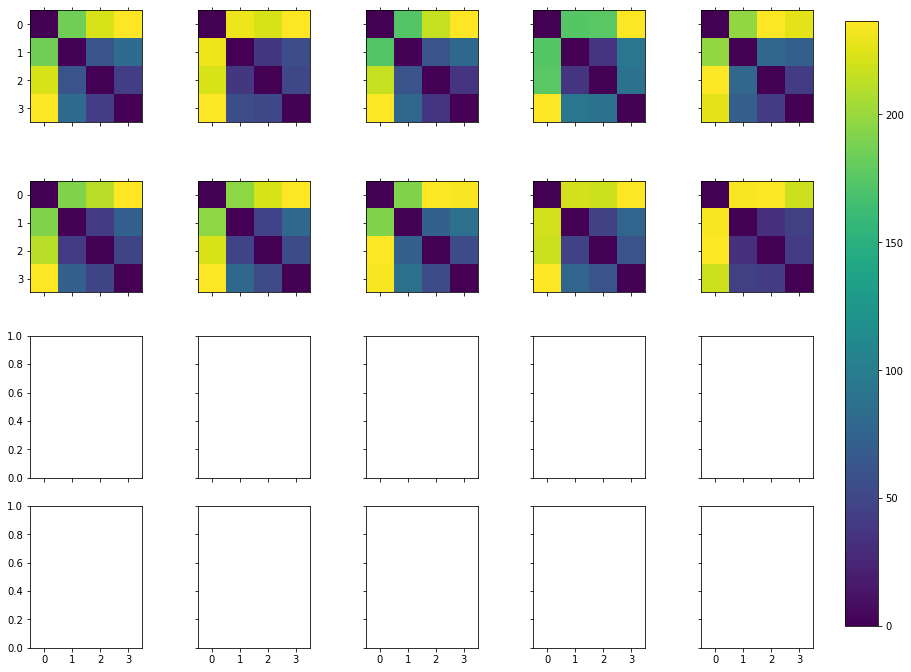

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances



#cn_stopwords = []

tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall')
model = GPT2LMHeadModel.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall', output_attentions=True).eval()

# corpus
with open("F:/project/Attention/corpus2.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]
  

fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharex='col', sharey='row',
                        gridspec_kw={'wspace':0.5, 'hspace':0.2, 'right':0.85})

all_sim = []

for corpus_index, text in enumerate(corpus):  
    sentences = text.split('。')[:-1]  
    if not sentences: continue  

    input_text = "[CLS] " + "[SEP] [CLS] ".join(sentences) + "[SEP]"

    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)

    input_ids = inputs['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    cls_positions = [pos for pos, token in enumerate(tokens) if token == "[CLS]"]
    
    num_sentences = len(cls_positions)-1
    
    all_embeddings = outputs[0][0, :, :]
    
    sentence_sim = np.zeros((num_sentences, num_sentences))

    for i in range(num_sentences):
        for j in range(num_sentences):
            emb_i = all_embeddings[cls_positions[i + 1]]
            emb_j = all_embeddings[cls_positions[j + 1]]
            sentence_sim[i,j] = euclidean_distances(emb_i.detach().numpy().reshape(-1,1).T, emb_j.detach().numpy().reshape(-1,1).T)


    all_sim.append(sentence_sim)

    row = corpus_index // 5  
    col = corpus_index % 5  
    ax = axs[row, col]
    im = ax.matshow(sentence_sim, cmap='viridis')

    if col == 0:
        ax.set_yticks(range(1,len(sentences)+1))

cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7]) 
fig.colorbar(im, cax=cbar_ax)

[[         nan          nan          nan          nan]
 [170.20332336          nan          nan          nan]
 [203.91186523  56.53132248          nan          nan]
 [217.47288513  76.44101715  39.78285217          nan]]


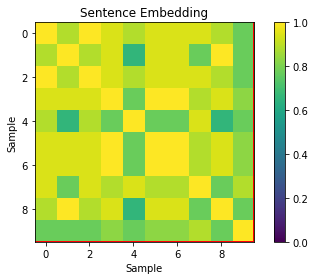

In [ ]:
def transform_matrix(matrix):
    tril_indices = np.tril_indices_from(matrix, k=-1)
    transformed_matrix = np.full(matrix.shape, np.nan) 
    transformed_matrix[tril_indices] = matrix[tril_indices]  
    return transformed_matrix

cut_matrices2 = []

for matrix in all_sim:
    cut_matrix = transform_matrix(matrix)
    cut_matrices2.append(cut_matrix)

print(cut_matrices2[0])

from scipy.stats import spearmanr
def calc_spearman_matrices(cut_matrices, layers=12, samples=15):
    layer_matrices = []
    for layer in range(layers):
        spearman_matrix = np.zeros((samples, samples))
        for i in range(samples):
            for j in range(samples):
                matrix_i = cut_matrices[i*layers + layer]
                matrix_j = cut_matrices[j*layers + layer]
                flat_i = matrix_i.flatten()
                flat_j = matrix_j.flatten()
                valid_indices = ~np.isnan(flat_i) & ~np.isnan(flat_j)

                m1 = ((flat_i[valid_indices]) - np.mean(flat_i[valid_indices]))/np.std(flat_i[valid_indices])
                m2 = ((flat_j[valid_indices]) - np.mean(flat_j[valid_indices]))/np.std(flat_j[valid_indices])
                rho, _ = spearmanr(m1, m2)
                spearman_matrix[i, j] = abs(rho)  # only abs value
        layer_matrices.append(spearman_matrix)
    return layer_matrices

spearman_matrices = calc_spearman_matrices(cut_matrices2, 1, 10)


plt.imshow(spearman_matrices[0], cmap='viridis', vmin=0, vmax=1)
plt.title(f'Sentence Embedding')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.colorbar()
plt.axhline(y = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.axvline(x = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.tight_layout()
plt.show()

In [ ]:
flattened_matrices2 = []

for matrix in cut_matrices2:

    flattened_matrix = matrix.flatten()
    valid_indices = ~np.isnan(flattened_matrix)
    final = (flattened_matrix[valid_indices] - np.mean(flattened_matrix[valid_indices]))/np.std(flattened_matrix[valid_indices])
    flattened_matrices2.append(final)

flattened_matrices2 = np.array(flattened_matrices2)

print(flattened_matrices2[0])

[ 0.59470543  1.06294537 -0.98429406  1.25131932 -0.70773169 -1.21694437]


In [ ]:
save_path = 'F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-emb.txt'
np.savetxt(save_path, flattened_matrices2[:20], fmt='%f')  # fmt='%f' 指定保存为浮点数格式
print(f'emb matrices saved to {save_path}')

emb matrices saved to F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-emb.txt


Compare

0.921690767519466
0.921690767519466
0.921690767519466
0.921690767519466
0.921690767519466
0.921690767519466
0.921690767519466
0.921690767519466
0.921690767519466
0.921690767519466
0.921690767519466
0.921690767519466
0.0002054469078081856 0.00019460702037246938 0.008689583305966498 4.924014648993572e-13


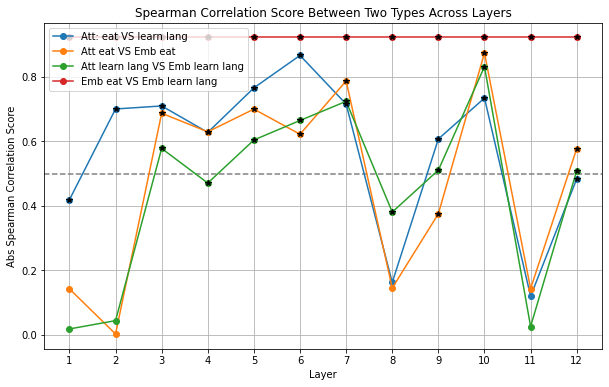

In [ ]:
#avg_emb_type1 = np.mean(flattened_matrices2[:5], axis=0)
#avg_emb_type2 = np.mean(flattened_matrices2[5:], axis=0)
avg_emb_type1 = np.hstack(flattened_matrices2[:5])
avg_emb_type2 = np.hstack(flattened_matrices2[5:])

from scipy.stats import spearmanr


n_samples = 10
n_layers = 12
n_samples_per_layer = 10
spearman_scores1 = []
spearman_scores2 = []
spearman_scores3 = []
spearman_scores4 = []
pvalue1 = []
pvalue2 = []
pvalue3 = []
pvalue4 = []
layers = range(1, n_layers + 1)

for i in range(n_layers):

    current_layer_matrices = []
    for sample in range(n_samples):

        index = sample * n_layers + i
        current_layer_matrices.append(flattened_matrices[index])
    
    avg_matrix_type1 = np.hstack(current_layer_matrices[:5])
    avg_matrix_type2 = np.hstack(current_layer_matrices[5:])
    #avg_matrix_type1 = np.mean(current_layer_matrices[:5], axis=0)
    #avg_matrix_type2 = np.mean(current_layer_matrices[5:], axis=0)
    
    rho1, p1 = spearmanr(avg_matrix_type1, avg_matrix_type2)
    spearman_scores1.append(abs(rho1))
    pvalue1.append(p1)

    rho2, p2 = spearmanr(avg_matrix_type1, avg_emb_type1)
    spearman_scores2.append(abs(rho2))
    pvalue2.append(p2)

    rho3, p3 = spearmanr(avg_matrix_type2, avg_emb_type2)
    spearman_scores3.append(abs(rho3))
    pvalue3.append(p3)

    rho4, p4 = spearmanr(avg_emb_type1, avg_emb_type2)
    spearman_scores4.append(abs(rho4))
    pvalue4.append(p4)
    print(abs(rho4))

significance_threshold = 0.05

plt.figure(figsize=(10, 6))
plt.axhline(y=0.5, linestyle="--", color='gray')
plt.plot(range(1, n_layers + 1), spearman_scores1, marker='o', linestyle='-', label='Att: eat VS learn lang')
plt.plot(range(1, n_layers + 1), spearman_scores2, marker='o', linestyle='-', label='Att eat VS Emb eat')
plt.plot(range(1, n_layers + 1), spearman_scores3, marker='o', linestyle='-', label='Att learn lang VS Emb learn lang')
plt.plot(range(1, n_layers + 1), spearman_scores4, marker='o', linestyle='-', label='Emb eat VS Emb learn lang')

for i, layer in enumerate(layers):
    if i == 3:
        print(pvalue1[i], pvalue2[i], pvalue3[i], pvalue4[i])
    if pvalue1[i] < significance_threshold:
        plt.plot(layer, spearman_scores1[i], marker='*', color='black')
    if pvalue2[i] < significance_threshold:
        plt.plot(layer, spearman_scores2[i], marker='*', color='black')
    if pvalue3[i] < significance_threshold:
        plt.plot(layer, spearman_scores3[i], marker='*', color='black')
    if pvalue4[i] < significance_threshold:
        plt.plot(layer, spearman_scores4[i], marker='*', color='black')

plt.xlabel('Layer')
plt.ylabel('Abs Spearman Correlation Score')
plt.title('Spearman Correlation Score Between Two Types Across Layers')
plt.legend(loc = "upper left")
plt.xticks(range(1, n_layers + 1))  # 设置x轴的刻度
plt.grid(True)
plt.show()